In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv("insurance_claims.csv")
df.drop(columns=['_c39', 'policy_number', 'policy_bind_date', 'incident_date', 'auto_make', 'auto_model', 'insured_zip'], inplace=True, errors='ignore')
df.replace("?", np.nan, inplace=True)
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})

X = df.drop(columns=['fraud_reported'])
y = df['fraud_reported']


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [26]:
import xgboost as xgb
from sklearn.metrics import classification_report

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)
model.fit(X_train_processed, y_train)
print(classification_report(y_test, model.predict(X_test_processed)))


              precision    recall  f1-score   support

           0       0.88      0.87      0.87       151
           1       0.61      0.63      0.62        49

    accuracy                           0.81       200
   macro avg       0.74      0.75      0.75       200
weighted avg       0.81      0.81      0.81       200



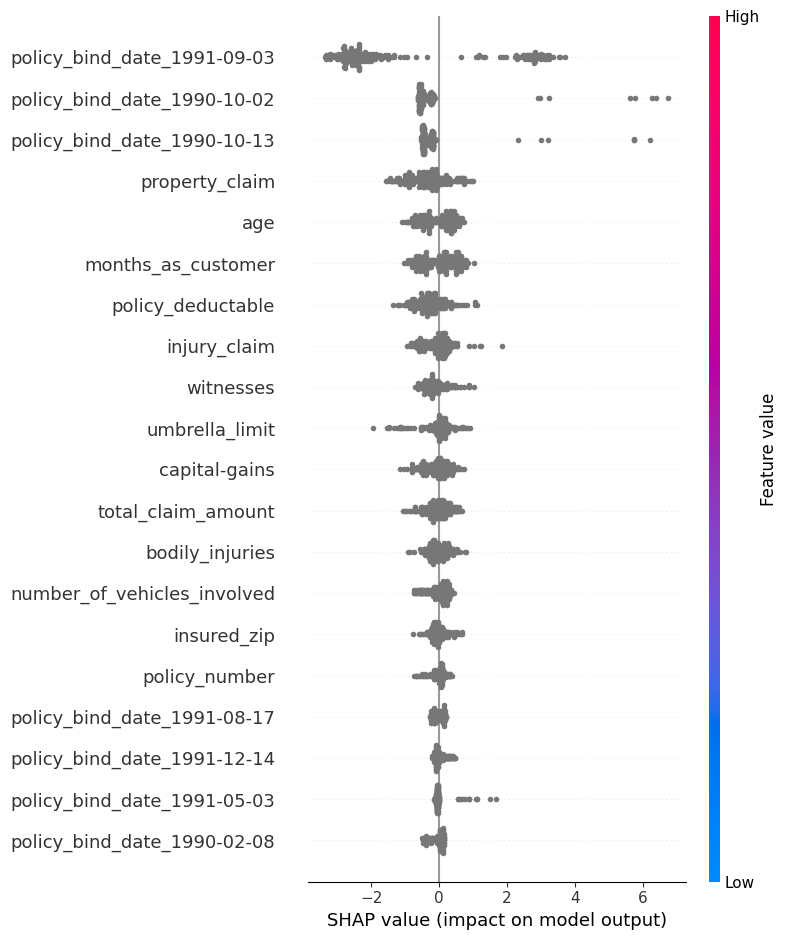

In [27]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(model)
shap_values = explainer(X_test_processed)

# Plot most important features
shap.summary_plot(shap_values, features=X_test_processed, feature_names=all_features)

In [28]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso.fit(X_train_processed)

output_df = X_test.copy()
output_df["Fraud_Probability"] = model.predict_proba(X_test_processed)[:, 1]
output_df["Anomaly_Score"] = iso.decision_function(X_test_processed)
output_df["Anomaly_Flag"] = iso.predict(X_test_processed)
output_df["Actual"] = y_test.values
output_df["Predicted"] = model.predict(X_test_processed)

output_df.to_csv("flagged_claims_output.csv", index=False)


In [29]:
# Get fraud probability scores (score for class 1)
fraud_scores = model.predict_proba(X_test_processed)[:, 1]

# Create output DataFrame
output_df = X_test.copy()
output_df["Actual_Label"] = y_test.values
output_df["Fraud_Probability"] = fraud_scores

# Assign priority based on risk score
def assign_priority(score):
    if score >= 0.85:
        return "High"
    elif score >= 0.5:
        return "Medium"
    else:
        return "Low"

output_df["Priority"] = output_df["Fraud_Probability"].apply(assign_priority)

# Sort by fraud risk (descending)
investigation_queue = output_df.sort_values(by="Fraud_Probability", ascending=False)

# Show top 10 suspicious claims
print(investigation_queue.head(10)[["Fraud_Probability", "Priority", "Actual_Label"]])


     Fraud_Probability Priority  Actual_Label
56            0.997077     High             0
919           0.995484     High             1
561           0.995299     High             1
183           0.993621     High             1
60            0.992237     High             1
914           0.991413     High             0
625           0.989291     High             0
251           0.986719     High             1
514           0.985995     High             0
888           0.982609     High             0


In [30]:
# Get feature names after transformation
ohe_features = preprocessor.named_transformers_["cat"]["encoder"].get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(ohe_features)

# Feature importance from the trained model
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Show top features
print("Top Important Features for Fraud Prediction:")
print(feature_importance_df.head(10))


Top Important Features for Fraud Prediction:
                               Feature  Importance
50               insured_hobbies_chess    0.095384
51           insured_hobbies_cross-fit    0.086220
78      incident_severity_Major Damage    0.084436
59                insured_hobbies_polo    0.033618
54                insured_hobbies_golf    0.030928
70           insured_relationship_wife    0.026499
53            insured_hobbies_exercise    0.020979
39  insured_occupation_priv-house-serv    0.019966
83          authorities_contacted_Fire    0.019566
32     insured_occupation_armed-forces    0.018828


In [31]:
investigation_queue.to_csv("flagged_claims.csv", index=False)